# 进阶案例：中低阶API实现手写数字识别

[![下载Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_notebook.png)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/master/tutorials/zh_cn/advanced/mindspore_lenet_mnist.ipynb)&emsp;[![下载样例代码](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_download_code.png)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/master/tutorials/zh_cn/advanced/mindspore_lenet_mnist.py)&emsp;[![查看源文件](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_source.png)](https://gitee.com/mindspore/docs/blob/master/tutorials/source_zh_cn/advanced/lenet_mnist.ipynb)

MindSpore向用户提供了高阶、中阶和低阶3个不同层次的API，详细内容参见[基本介绍-层次结构内容章节](https://www.mindspore.cn/tutorials/zh-CN/master/beginner/introduction.html#层次结构)。本章将使用MindSpore提供的中低阶API，以LeNet网络模型为例，实现深度学习中的手写数字识别任务。

本章将会介绍配置信息和使用MindSpore提供的中低阶API，实现自定义网络模型、数据加载，自定义训练、验证、推理流程。


## 数据集下载和处理

示例中用到的MNIST数据集是由10类28∗28的灰度图片组成，训练数据集包含60000张图片，测试数据集包含10000张图片。

![mnist](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/tutorials/source_zh_cn/beginner/images/mnist.png)

### 数据集下载

以下示例代码是MNIST数据集下载并解压到指定位置。

In [1]:
import os
from mindvision.dataset import DownLoad

# 构建数据集下载
def download_data(data_name, dl_path_mnist):
    dl = DownLoad()
    # MNIST数据集保存路径

    # 数据集的链接
    dl_url_mnist = "http://yann.lecun.com/exdb/mnist/"

    dl_url_mnist_data = [dl_url_mnist + data_name[0],
                         dl_url_mnist + data_name[1]]

    # 下载MNIST数据集并解压
    dl.download_and_extract_archive(url=dl_url_mnist_data[0], download_path=dl_path_mnist)
    dl.download_and_extract_archive(url=dl_url_mnist_data[1], download_path=dl_path_mnist)

    # 删除压缩文件
    for i in os.listdir(dl_path_mnist):
        if i in data_name:
            os.remove(dl_path_mnist + i)

data_name_train = ["train-images-idx3-ubyte.gz", "train-labels-idx1-ubyte.gz"]
dl_path_mnist_train = "./mnist/train/"
data_name_test = ["t10k-images-idx3-ubyte.gz", "t10k-labels-idx1-ubyte.gz"]
dl_path_mnist_test = "./mnist/test/"
# 下载训练集
download_data(data_name_train, dl_path_mnist_train)
# 下载验证集
download_data(data_name_test, dl_path_mnist_test)

### 数据集加载

使用[mindspore.dataset.MnistDataset](https://www.mindspore.cn/docs/zh-CN/master/api_python/dataset/mindspore.dataset.MnistDataset.html#mindspore.dataset.MnistDataset)接口加载MNIST数据集，使用数据集增强函数生成训练数据，通过定义的`create_data_to_net`方法将生成的60000个数据增强为7500组shape为(8, 1, 32, 32)的数据集。示例代码如下：

The size of steps:  7500
The x label value shape: (8, 1, 32, 32)
The y label value shape: (8,)


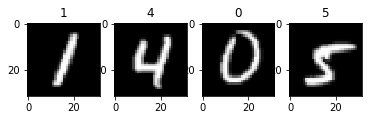

In [2]:
import mindspore.dataset as ds
import mindspore.dataset.vision as vision
from mindspore.dataset.transforms import Compose
import matplotlib.pyplot as plt

# 构建数据预处理
def create_data_to_net(minist_path, batch_size, image_size, sampler=False):
    if sampler:
        sampler = ds.RandomSampler(num_samples=4)
    else:
        sampler = None

    dataset_mnist2 = ds.MnistDataset(minist_path, sampler=sampler)

    transforms_list = [
        vision.Resize(size=image_size),
        vision.HWC2CHW()]
    compose_trans = Compose(transforms_list)
    dataset_mnist2 = dataset_mnist2.map(operations=compose_trans, input_columns=["image"])

    dataset_mnist = dataset_mnist2.batch(batch_size, drop_remainder=True)

    return dataset_mnist

batch_size = 8
image_size = [32, 32]

train_data = create_data_to_net(dl_path_mnist_train, batch_size, image_size)
print("The size of steps: ", train_data.get_dataset_size())

dict_datasets = next(train_data.create_dict_iterator())

print("The x label value shape:", dict_datasets["image"].shape)
print("The y label value shape:", dict_datasets["label"].shape)

# 数据可视化
ds_test = train_data.create_dict_iterator()
data = next(ds_test)
images = data["image"].asnumpy()
labels = data["label"].asnumpy()
plt.figure()
for i in range(1, 5):
    plt.subplot(1, 4, i)
    plt.imshow(images[i-1][0], interpolation="None", cmap="gray")
    plt.title(labels[i-1])
plt.show()

## 定义网络模型

按照LeNet的网络结构，LeNet除去输入层共有7层，其中有2个卷积层，2个子采样层，3个全连接层。模型结构如下图：

![](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/tutorials/source_zh_cn/beginner/images/lenet.png)

`mindspore.nn`类是构建所有网络的基类，也是网络的基本单元。当用户需要自定义网络时，可以继承`nn.Cell`类，并重写`__init__`方法和`construct`方法。

为了便于管理和组成更复杂的网络，`mindspore.nn`提供了容器对网络中的子模型块或模型层进行管理，有`nn.CellList`和`nn.SequentialCell`两种方式。这里选择了使用`nn.CellList`方法。


In [3]:
from mindspore import nn
from mindspore.common.initializer import Normal

# 自定义网络
class MyNet(nn.Cell):
    def __init__(self, num_classes=10, num_channel=1):
        super(MyNet, self).__init__()
        layers = [nn.Conv2d(num_channel, 6, 5, pad_mode='valid'),
                  nn.ReLU(),
                  nn.MaxPool2d(kernel_size=2, stride=2),
                  nn.Conv2d(6, 16, 5, pad_mode='valid'),
                  nn.ReLU(),
                  nn.MaxPool2d(kernel_size=2, stride=2),
                  nn.Flatten(),
                  nn.Dense(16 * 5 * 5, 120, weight_init=Normal(0.02)),
                  nn.ReLU(),
                  nn.Dense(120, 84, weight_init=Normal(0.02)),
                  nn.ReLU(),
                  nn.Dense(84, num_classes, weight_init=Normal(0.02))]
        # 使用CellList对网络进行管理
        self.build_block = nn.CellList(layers)

    def construct(self, x):
        # for循环执行网络
        for layer in self.build_block:
            x = layer(x)
        return x

## 自定义损失函数

损失函数（Loss Function）用于衡量预测值与真实值差异的程度。深度学习中，模型训练就是通过不停地迭代来缩小损失函数值的过程，因此在模型训练过程中损失函数的选择非常重要，定义一个好的损失函数可以帮助损失函数值更快收敛，达到更好的精度。

[mindspore.nn](https://www.mindspore.cn/docs/zh-CN/master/api_python/mindspore.nn.html#损失函数)提供了许多通用损失函数供用户选择， 也支持用户根据需要自定义损失函数。

自定义损失函数类时，既可以继承网络的基类`nn.Cell`，也可以继承损失函数的基类`nn.LossBase`。`nn.LossBase`在`nn.Cell`的基础上，提供了`get_loss`方法，利用`reduction`参数对损失值求和或求均值，输出一个标量。下面将使用继承LossBase的方法来定义交叉熵损失函数(Cross Entropy Loss)，这里需要重写`__init__`方法和`construct`方法，使用`get_loss`方法计算损失。示例代码如下：

In [4]:
from mindspore import ops
from mindspore import Tensor
import mindspore.common.dtype as mstype

class MyLoss(nn.LossBase):
    """定义损失函数"""
    def __init__(self, reduction='none'):
        super(MyLoss, self).__init__(reduction)
        self.reduction = reduction
        self.softmax_cross_entropy = ops.SoftmaxCrossEntropyWithLogits()
        self.one_hot = ops.OneHot()
        self.on_value = Tensor(1.0, mstype.float32)
        self.off_value = Tensor(0., mstype.float32)
        self.sparse_softmax_cross_entropy = ops.SparseSoftmaxCrossEntropyWithLogits()

    def construct(self, logits, labels):
        if self.reduction == 'mean':
            x = self.sparse_softmax_cross_entropy(logits, labels)
            return x
        labels = self.one_hot(labels, ops.functional.shape(logits)[-1], self.on_value, self.off_value)
        x = self.softmax_cross_entropy(logits, labels)[0]
        return self.get_loss(x)

## 自定义优化器

优化器在模型训练过程中，用于计算和更新网络参数，合适的优化器可以有效减少训练时间，提高模型性能。

[mindspore.nn](https://www.mindspore.cn/docs/zh-CN/master/api_python/mindspore.nn.html#优化器)提供了许多通用的优化器供用户选择，同时也支持用户根据需要自定义优化器。

自定义优化器时可以继承优化器基类`nn.Optimizer`，重写`__init__`方法和`construct`方法实现参数的更新。

如下示例实现自定义优化器Momentum（带动量的SGD算法）：

$$ v_{t+1} = v_t × u+grad \tag{1}$$

$$p_{t+1} = p_t - lr × v_{t+1} \tag{2}$$

其中，$grad$(梯度) 、$lr$(学习率) 、$p$(权重参数) 、$v$(动量参数（Momentum）) 和 $u$(初始速度)。

In [5]:
class Momentum(nn.Optimizer):
    """定义优化器"""
    def __init__(self, params, learning_rate, momentum=0.9):
        super(Momentum, self).__init__(learning_rate, params)
        self.moments = self.parameters.clone(prefix="moments", init="zeros")
        self.momentum = momentum
        self.opt = ops.ApplyMomentum()

    def construct(self, gradients):
        # 待更新的权重参数
        params = self.parameters
        success = None
        for param, mom, grad in zip(params, self.moments, gradients):
            success = self.opt(param, mom, self.learning_rate, grad, self.momentum)
        return success

## 自定义训练和验证流程

`mindspore.Model`提供了`train`和`eval`的接口方便用户在训练过程中使用，但此接口无法适用于所有场景，比如多数据多标签场景，在这些场景下用户需自行定义训练过程。

本节主要使用线性回归的例子来简单介绍自定义训练流程。首先定义损失网络，将前向网络与损失函数连接起来；然后定义训练流程，训练流程一般继承`nn.TrainOneStepCell`，`nn.TrainOneStepCell`封装了损失网络和优化器，用来实现反向传播网络以更新权重参数。

### 定义损失网络

定义损失网络`MyWithLossCell`，将前向网络与损失函数连接起来。代码如下：

In [6]:
class MyWithLossCell(nn.Cell):
    """定义损失网络"""

    def __init__(self, network, loss_fn):
        """实例化时传入前向网络和损失函数作为参数"""
        super(MyWithLossCell, self).__init__(auto_prefix=False)
        self.network = network
        self.loss_fn = loss_fn

    def construct(self, data, label):
        """连接前向网络和损失函数"""
        out = self.network(data)
        return self.loss_fn(out, label)

### 定义训练流程

定义训练流程`MyTrainStep`，该类继承`nn.TrainOneStepCell`，`nn.TrainOneStepCell`封装了损失网络和优化器，在执行训练时通过`ops.GradOperation`算子来进行梯度的获取，通过优化器来实现权重的更新。

In [7]:
class MyTrainStep(nn.TrainOneStepCell):
    """定义训练流程"""

    def __init__(self, network, optimizer):
        """参数初始化"""
        super(MyTrainStep, self).__init__(network, optimizer)
        self.grad = ops.GradOperation(get_by_list=True)

    def construct(self, data, label):
        """构建训练过程"""
        weights = self.weights
        loss = self.network(data, label)
        grads = self.grad(self.network, weights)(data, label)
        self.optimizer(grads)
        return loss

### 定义验证流程

定义验证流程`MyWithEvalCell`，该类继承`nn.Cell`，这里需要用损失函数连接前向网络，需要输出损失、模型预测结果和标签值。

In [8]:
class MyWithEvalCell(nn.Cell):
    def __init__(self, network, loss_fn):
        super(MyWithEvalCell, self).__init__(auto_prefix=False)
        self._network = network
        self._loss_fn = loss_fn

    def construct(self, data, label):
        outputs = self._network(data)
        label = ops.functional.mixed_precision_cast(mstype.float32, label)
        outputs = ops.functional.cast(outputs, mstype.float32)
        loss = self._loss_fn(outputs, label)
        return loss, outputs, label

### 执行训练和验证

代码如下：

In [10]:
import time
import mindspore as ms

epochs = 10

# 生成数据
train_data = create_data_to_net(dl_path_mnist_train, batch_size, image_size)
eval_data = create_data_to_net(dl_path_mnist_test, batch_size, image_size)

# 初始化网络
net = MyNet()

# 初始化损失函数
loss = MyLoss(reduction='mean')

# 初始化优化器
opt = Momentum(net.trainable_params(), learning_rate=0.0008, momentum=0.9)

# 构建损失网络
net_with_loss = MyWithLossCell(net, loss)

# 构建训练网络
train_net = MyTrainStep(net_with_loss, opt)

# 设置网络为训练模式
train_net.set_train()

# 构建验证网络
eval_net = MyWithEvalCell(net, loss)
eval_net.set_train(False)
loss = nn.Loss()
metric = nn.Accuracy('classification')

# 真正训练迭代过程
steps = train_data.get_dataset_size()

for epoch in range(epochs):
    start = time.time()  # 开始时间
    for data in train_data.create_dict_iterator():
        result = train_net(ms.Tensor(data['image'], ms.float32), ms.Tensor(data["label"], ms.int32))
    end = time.time()  # 结束时间
    time_ = round(end - start, 2)
    print(f"Epoch: [{epoch} / {epochs}], "
          f"step: [{steps} / {steps}], "
          f"epoch_time: {time_} s, "
          f"loss: {result}")
    # 保存权重
    ms.save_checkpoint(train_net, f"./ckpt/epoch_{epoch}_MyNet.ckpt")

    metric.clear()
    loss.clear()

    for data_eval1 in eval_data.create_dict_iterator():
        outputs = eval_net(ms.Tensor(data_eval1['image'], ms.float32), ms.Tensor(data_eval1["label"], ms.int32))

        metric.update(outputs[1], outputs[2])
        loss.update(outputs[0])

    # 评估结果
    metric_result = metric.eval()
    loss_result = loss.eval()

    print(f"Acc: {metric_result} , "
          f"loss: {loss_result}")

Epoch: [0 / 10], step: [7500 / 7500], epoch_time: 24.67 s, loss: 0.118552424
Acc: 0.9823 , loss: 0.06053082474194307
Epoch: [1 / 10], step: [7500 / 7500], epoch_time: 16.58 s, loss: 0.000869977
Acc: 0.9811 , loss: 0.06130807545149691
Epoch: [2 / 10], step: [7500 / 7500], epoch_time: 15.88 s, loss: 0.004620093
Acc: 0.9854 , loss: 0.049185324527783084
Epoch: [3 / 10], step: [7500 / 7500], epoch_time: 15.2 s, loss: 0.0011356405
Acc: 0.984 , loss: 0.06363802380347722
Epoch: [4 / 10], step: [7500 / 7500], epoch_time: 14.83 s, loss: 0.00013104476
Acc: 0.9888 , loss: 0.03969318263347805
Epoch: [5 / 10], step: [7500 / 7500], epoch_time: 15.15 s, loss: 0.03317738
Acc: 0.9879 , loss: 0.04228383499707758
Epoch: [6 / 10], step: [7500 / 7500], epoch_time: 14.38 s, loss: 0.00040215958
Acc: 0.9891 , loss: 0.03972244702143328
Epoch: [7 / 10], step: [7500 / 7500], epoch_time: 15.11 s, loss: 0.0057265083
Acc: 0.9862 , loss: 0.058643047131567004
Epoch: [8 / 10], step: [7500 / 7500], epoch_time: 18.18 s, 

## 构建推理流程

我们使用生成的模型进行单个图片数据的分类预测，具体步骤如下：

> - 被预测的图片会随机生成，每次运行结果可能会不一样。
> - 代码使用了Tensor模块，阅读更多有关[张量Tensor](https://www.mindspore.cn/tutorials/zh-CN/master/beginner/tensor.html)的信息。

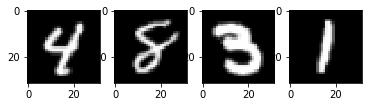

label:  [4, 8, 3, 1]
result:  [4, 8, 3, 1]


In [12]:
from mindspore import load_checkpoint, load_param_into_net

batch_size = 1
image_size = [32, 32]

# 初始化网络
net = MyNet()

# 初始化损失函数
loss = MyLoss(reduction='mean')

# 加载权重文件
param_dict = load_checkpoint(f"./ckpt/epoch_9_MyNet.ckpt")
load_param_into_net(net, param_dict)

eval_net = MyWithEvalCell(net, loss)
eval_net.set_train(False)

# 数据加载
infer_data = create_data_to_net(dl_path_mnist_test, batch_size, image_size,
                                sampler=True)
result = []
label = []
i = 1
plt.figure()
for data in infer_data.create_dict_iterator():
    # 数据可视化
    images = data["image"].asnumpy()
    labels = data["label"].asnumpy()
    plt.subplot(1, 4, i)
    plt.imshow(images[0][0], interpolation="None", cmap="gray")
    i = i + 1

    # 模型推理
    outputs = eval_net(ms.Tensor(data["image"], ms.float32), ms.Tensor(data["label"], ms.int32))
    indices = outputs[1].argmax(axis=1)
    result.append(indices.asnumpy()[0])
    label.append(outputs[2].asnumpy()[0])
plt.show()
print("label: ", label)
print("result: ", result)